In [2]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("Week3_Delay_Analysis") \
    .getOrCreate()


In [4]:
from google.colab import files
uploaded = files.upload()


Saving customers.csv to customers.csv


In [5]:
from google.colab import files
uploaded = files.upload()

Saving orders.csv to orders (1).csv


In [6]:
orders = spark.read.csv("orders.csv", header=True, inferSchema=True)
customers = spark.read.csv("customers.csv", header=True, inferSchema=True)

orders.printSchema()
customers.printSchema()


root
 |-- order_id: integer (nullable = true)
 |-- customer_id: integer (nullable = true)
 |-- order_date: date (nullable = true)
 |-- delivery_date: date (nullable = true)
 |-- status_description: string (nullable = true)

root
 |-- customer_id: integer (nullable = true)
 |-- name: string (nullable = true)
 |-- region: string (nullable = true)
 |-- email: string (nullable = true)
 |-- phone: long (nullable = true)
 |-- registration_date: date (nullable = true)



In [14]:
from pyspark.sql.functions import to_date, current_date, datediff, col

# Convert delivery_date to date and calculate delay
orders = orders.withColumn("delivery_date", to_date("delivery_date"))
orders = orders.withColumn("delay_days", datediff(current_date(), "delivery_date"))

# Consider delayed if delay_days > 0
orders = orders.withColumn("delayed", (col("delay_days") > 0).cast("int"))

orders.select("order_id", "customer_id", "delivery_date", "delay_days", "delayed").show()


+--------+-----------+-------------+----------+-------+
|order_id|customer_id|delivery_date|delay_days|delayed|
+--------+-----------+-------------+----------+-------+
|       1|          6|   2025-07-23|         9|      1|
|       2|          4|   2025-07-24|         8|      1|
|       3|          7|   2025-07-23|         9|      1|
|       4|          1|   2025-07-28|         4|      1|
|       5|          7|   2025-07-18|        14|      1|
|       6|          1|   2025-07-17|        15|      1|
|       7|          3|   2025-07-17|        15|      1|
|       8|          9|   2025-07-15|        17|      1|
|       9|          4|   2025-07-24|         8|      1|
|      10|         10|   2025-07-22|        10|      1|
|      11|          2|   2025-07-28|         4|      1|
|      12|          9|   2025-07-19|        13|      1|
|      13|          4|   2025-07-26|         6|      1|
|      14|         10|   2025-07-21|        11|      1|
|      15|          3|   2025-07-28|         4| 

In [13]:
joined_df = orders.join(customers, on="customer_id", how="inner")
joined_df.select("order_id", "region", "delayed", "status_description").show()


+--------+---------+-------+--------------------+
|order_id|   region|delayed|  status_description|
+--------+---------+-------+--------------------+
|       1|Hyderabad|      1|Courier not assigned|
|       2|Hyderabad|      1|       Wrong address|
|       3|Hyderabad|      1|             On time|
|       4|Hyderabad|      1|       Wrong address|
|       5|Hyderabad|      1| Delayed due to rain|
|       6|Hyderabad|      1|       Wrong address|
|       7|  Chennai|      1|Courier not assigned|
|       8|Hyderabad|      1| Delayed due to rain|
|       9|Hyderabad|      1| Delayed due to rain|
|      10|Hyderabad|      1|     Packaging delay|
|      11|   Mumbai|      1|       Wrong address|
|      12|Hyderabad|      1|   Vehicle breakdown|
|      13|Hyderabad|      1|     Packaging delay|
|      14|Hyderabad|      1|     Packaging delay|
|      15|  Chennai|      1|     Logistics issue|
|      16|Hyderabad|      1|Courier not assigned|
|      17|    Delhi|      1|             On time|


In [9]:
# Group by region and sum delayed column
region_delay_summary = joined_df.groupBy("region") \
    .sum("delayed") \
    .withColumnRenamed("sum(delayed)", "total_delayed_orders") \
    .orderBy(col("total_delayed_orders").desc())

region_delay_summary.show()


+---------+--------------------+
|   region|total_delayed_orders|
+---------+--------------------+
|Hyderabad|                  15|
|  Chennai|                   3|
|   Mumbai|                   1|
|    Delhi|                   1|
+---------+--------------------+



In [10]:
region_delay_summary.coalesce(1).write.csv("region_delay_summary", header=True)


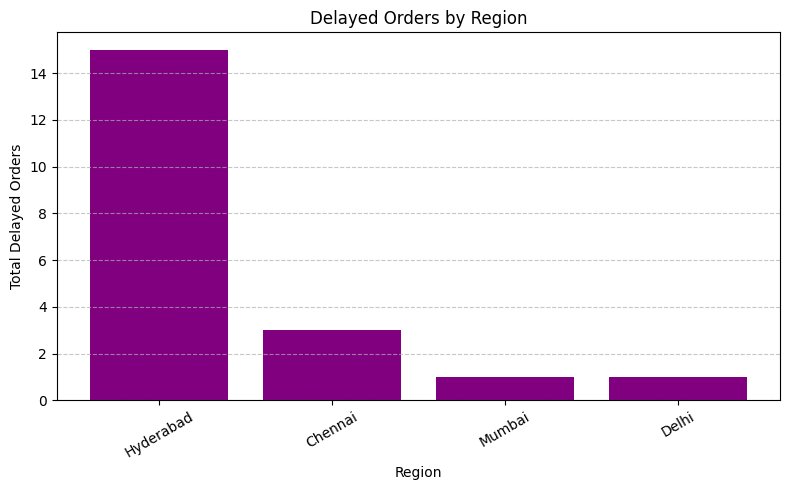

In [16]:
pandas_df = region_delay_summary.toPandas()
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 5))
plt.bar(pandas_df["region"], pandas_df["total_delayed_orders"], color="purple")
plt.xlabel("Region")
plt.ylabel("Total Delayed Orders")
plt.title("Delayed Orders by Region")
plt.xticks(rotation=30)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()
